In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [101]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import os
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.applications import vgg16
from keras.models import Sequential
from keras.layers import Flatten, BatchNormalization, Dropout, MaxPooling2D, Conv2D, Activation, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers.advanced_activations import PReLU, ReLU

In [3]:
tf.compat.v1.set_random_seed(2022)

In [102]:
paintings = pd.read_csv("train_info.csv")
paintings.head(15)

,filename,artist,title,style,genre,date
0,102257.jpg,5b39c876740bfc1cfaf544721c43cac3,Uriel,Color Field Painting,abstract,1955.0
1,75232.jpg,5b39c876740bfc1cfaf544721c43cac3,Vir Heroicus Sublimis,Color Field Painting,abstract,1950.0
2,29855.jpg,96e5bc98488ed589b9bf17ad9fd09371,Night March of a Hundred Demons (left half),Yamato-e,mythological painting,NaN
3,62252.jpg,5b39c876740bfc1cfaf544721c43cac3,"Who’s Afraid of Red, Yellow and Blue II",Color Field Painting,abstract,NaN
4,63861.jpg,5b39c876740bfc1cfaf544721c43cac3,Black Fire I,Color Field Painting,abstract,1963.0
5,53180.jpg,782192dc825c7c1149825adcb7caacbc,Camellia and Bush Warbler,Ukiyo-e,bird-and-flower painting,1844
6,70944.jpg,afdfc43410410892bc9d1c4d3c3d6220,Forbidden Land,Surrealism,landscape,1937.0
7,59792.jpg,9f0984ce62483f294fc666d74e0974f6,Descent from the cross,Northern Renaissance,religious painting,NaN
8,48138.jpg,3a40b18a78ceb822961393c50bdb522b,Snowy landscape with a woman brandishing a bro...,Ukiyo-e,landscape,NaN
9,99442.jpg,d09f796f2b0aa11dffc88badd9806119,Storm at sea,Romanticism,marina,1873


In [103]:
paintings = paintings[["filename", "style"]]
#styles = {"Art Nouveau (Modern)": 0, "Realism": 1, "Symbolism": 2, "Impressionism": 3, "Ukiyo-e": 4, "Cubism": 5}
styles = {"Realism": 0,"Impressionism": 1}
paintings = paintings.loc[paintings['style'].isin(styles)]
print(paintings["style"].unique())
paintings.head(10)

['Realism' 'Impressionism']


,filename,style
16,28908.jpg,Realism
56,633.jpg,Realism
77,19834.jpg,Realism
80,45276.jpg,Realism
84,80938.jpg,Realism
101,23209.jpg,Realism
104,100829.jpg,Realism
108,95360.jpg,Impressionism
151,88558.jpg,Realism
152,49757.jpg,Impressionism


In [ ]:
# from imblearn.under_sampling import RandomUnderSampler

# rus = RandomUnderSampler(sampling_strategy='not minority', random_state=1)
# df_balanced, balanced_labels = rus.fit_resample(paintings, paintings['style'])

In [4]:
paintings["style"].value_counts()

Impressionism           8220
Realism                 8112
Art Nouveau (Modern)    3779
Symbolism               2626
Cubism                  1316
Ukiyo-e                 1137
Name: style, dtype: int64

In [104]:
def load_images(folder, where):
    images = []
    stl = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None and filename in paintings["filename"].unique():
            img = cv2.resize(img, (256, 256))
            img = img_to_array(img)
            img = vgg16.preprocess_input(img)
            # to write into folder
            # fol = where + (paintings.loc[paintings['filename'] == filename, 'style'].iloc[0]) + "/" + filename
            # cv2.imwrite(fol, img)
            images.append(img)
            stl.append(styles[paintings.loc[paintings['filename'] == filename, 'style'].iloc[0]])

    return images, stl

img_list, im_styles = load_images("/content/drive/MyDrive/train_2", "/content/drive/MyDrive/train/")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


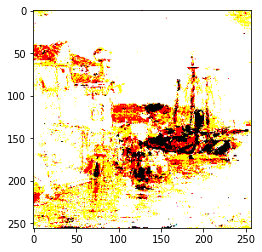

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Impressionism


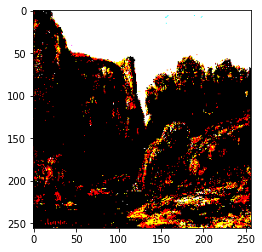

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Realism


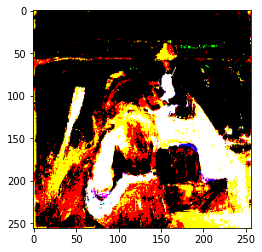

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Impressionism


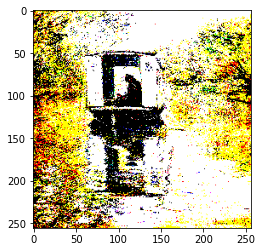

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Impressionism


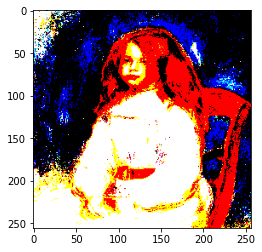

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Impressionism


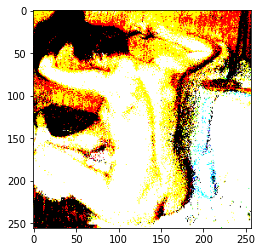

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Impressionism


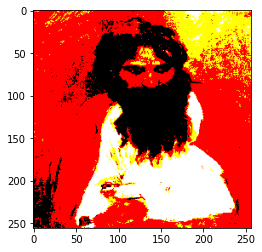

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Realism


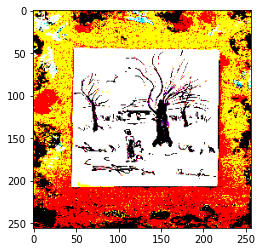

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Impressionism


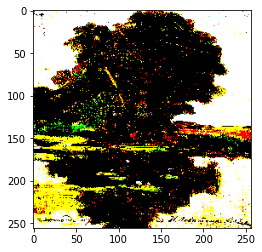

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Realism


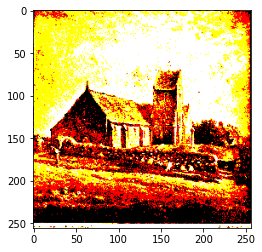

Realism


In [105]:
for image, num in zip(img_list[:10], im_styles[:10]):
    plt.imshow(image)
    plt.show()
    print(list(styles.keys())[list(styles.values()).index(num)])

In [ ]:
def balance(images, classes):
    c = np.bincount(classes)
    n = c.min()
    cs = np.roll(np.cumsum(c), 1)
    cs[0] = 0
    i = np.arange(len(classes)) - cs[classes]
    m = i < n
    return images[m], classes[m]

img_list_np = np.array(img_list)
im_styles_np = np.asarray(im_styles)

b, b_s = balance(img_list_np, im_styles_np)

In [110]:
def model_cnn(in_shape=(256, 256, 3)):
    model = Sequential()
    
    model.add(Conv2D(16, (3, 3), input_shape=in_shape, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l=0.003)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l=0.003)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l=0.003)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l=0.003)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(550,activation="relu"))      #Adding the Hidden layer
    model.add(Dropout(0.1,seed = 2022))

    model.add(Dense(400,activation ="relu"))
    model.add(Dropout(0.3,seed = 2022))

    model.add(Dense(300,activation="relu"))
    model.add(Dropout(0.4,seed = 2022))

    model.add(Dense(200,activation ="relu"))
    model.add(Dropout(0.2,seed = 2022))

    model.add(Dense(6,activation = "softmax"))
    # adam=Adam(lr=0.001)
    # model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['acc'])
  
    adam = Adam(learning_rate=0.000074)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=adam, metrics=['accuracy'])
    return model

In [61]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 batch_normalization_49 (Bat  (None, 256, 256, 16)     1024      
 chNormalization)                                                
                                                                 
 p_re_lu_43 (PReLU)          (None, 256, 256, 16)      1048576   
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 128, 128, 64)      9280      
                                                                 
 batch_normalization_50 (Bat  (None, 128, 128, 64)    

If you read images, proccess them and store them into RAM

In [111]:
model = model_cnn()

In [108]:
img_list_1 = np.array(img_list)
im_styles_1 = np.asarray(im_styles)
trainX, testX, trainY, testY = train_test_split(img_list_1, im_styles_1, test_size=0.2, random_state=1)

In [112]:
history_model = model.fit(trainX, trainY, batch_size=16, epochs=5, verbose=1, validation_data=(testX, testY))

Epoch 1/5
88/88 [==============================] - 8s 74ms/step - loss: 4.8175 - accuracy: 0.5189 - val_loss: 3.4826 - val_accuracy: 0.5943
Epoch 2/5
88/88 [==============================] - 5s 54ms/step - loss: 3.8407 - accuracy: 0.5361 - val_loss: 3.4144 - val_accuracy: 0.6000
Epoch 3/5
88/88 [==============================] - 5s 54ms/step - loss: 3.5922 - accuracy: 0.5740 - val_loss: 3.4187 - val_accuracy: 0.5600
Epoch 4/5
88/88 [==============================] - 5s 54ms/step - loss: 3.4486 - accuracy: 0.6190 - val_loss: 3.2720 - val_accuracy: 0.6857
Epoch 5/5
88/88 [==============================] - 5s 55ms/step - loss: 3.3651 - accuracy: 0.6340 - val_loss: 3.2484 - val_accuracy: 0.6743


Balanced dataset, each class 550 images

In [98]:
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

train_dir = "/content/drive/MyDrive/mytrainbig"
validation_dir = "/content/drive/MyDrive/test"

train_generator=train_datagen.flow_from_directory(train_dir,batch_size=30,class_mode='categorical',target_size=(256,256))
# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,batch_size=30,class_mode = 'categorical',target_size=(256,256))

Found 3276 images belonging to 6 classes.
Found 277 images belonging to 6 classes.


In [100]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=150//30,
                    validation_steps=50//30,
                    epochs=30,
                    verbose=1)

Epoch 1/30
5/5 [==============================] - 1s 254ms/step - loss: 34.1779 - acc: 0.0933 - val_loss: 23.5571 - val_acc: 0.1333
Epoch 2/30
5/5 [==============================] - 1s 187ms/step - loss: 24.1110 - acc: 0.1667 - val_loss: 16.0360 - val_acc: 0.2667
Epoch 3/30
5/5 [==============================] - 1s 177ms/step - loss: 18.5142 - acc: 0.2000 - val_loss: 10.8084 - val_acc: 0.1333
Epoch 4/30
5/5 [==============================] - 1s 160ms/step - loss: 13.7598 - acc: 0.1429 - val_loss: 10.4067 - val_acc: 0.3667
Epoch 5/30
5/5 [==============================] - 1s 179ms/step - loss: 14.4194 - acc: 0.2000 - val_loss: 6.2705 - val_acc: 0.2000
Epoch 6/30
5/5 [==============================] - 1s 180ms/step - loss: 9.4787 - acc: 0.1533 - val_loss: 6.1697 - val_acc: 0.3333
Epoch 7/30
5/5 [==============================] - 1s 181ms/step - loss: 8.5635 - acc: 0.1867 - val_loss: 5.4938 - val_acc: 0.2000
Epoch 8/30
5/5 [==============================] - 1s 181ms/step - loss: 7.0638 - 

In [60]:
model.predict(validation_generator)

array([[nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       ...,
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan]], dtype=float32)

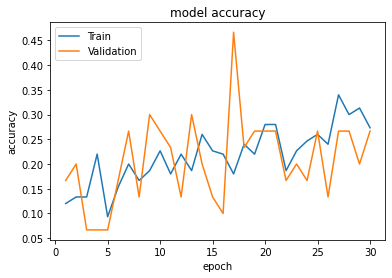

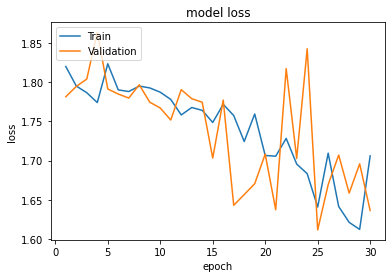

In [71]:
ep = [i for i in range(1, 31)]
plt.plot(ep, history.history['acc'])
plt.plot(ep, history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(ep, history.history['loss'])
plt.plot(ep, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# from sklearn.metrics import accuracy_score
# predictions = model.predict(np.array(img_list[:100]))
# print("accuracy: ", accuracy_score(np.asarray(im_styles[:100]), predictions))

In [ ]:
#print(predictions)